In [1]:
import numpy as np
from matplotlib import pyplot as plt

*a)*

In [2]:
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)
import sympy as sp

x = sp.symbols('x')
u_sym = sp.exp(-800*(x-0.4)**2) + 0.25 * sp.exp(-40*(x-0.8)**2)


u_double_diff = sp.exp(-800)

In [3]:
u_sym.subs(x,0)
u_sym.subs(x,1)

0.0504741294986639

*b)*

In [6]:
def compute_error_decrease(uc,uf,VXc,VXf,Old2New):
    
    N = len(VXc)-1
    err = np.zeros(N)

    for n, triple in enumerate(Old2New):

        i = triple[0]
        j = triple[2]
        k = triple[1]

        xi   = VXc[i]
        xj = VXc[j]
        xk  =  xi + (xj - xi)/2

        uci  = uc[i]
        ucj =  uc[j]

        ufi = uf[i]
        ufk = uf[k]
        ufj = uf[j]

        a  = (ucj - uci) / (xj - xi)
        a1 = (ufk - ufi) / (xk - xi)
        a2 = (ufj - ufk) / (xj - xk)

        b = uci - a * xi
        b1 = ufi - a1 * xi
        b2 = ufj - a2 * xj

        int1 = ((a-a1)**2/3) * (xk**3 - xi**3) + (b-b1)**2 * (xk - xi) + (a-a1)*(b-b1) * (xk**2 - xi**2)
        int2 = ((a-a2)**2/3) * (xj**3 - xk**3) + (b-b2)**2 * (xj - xk) + (a-a2)*(b-b2) * (xj**2 - xk**2)
        
        err[n] = np.sqrt(int1 + int2)

    return err

Test case

In [7]:
uc = np.array([0,0])
uf = np.array([0,0,1/2])

VXc = np.array([0,1])
VXf = np.array([0,1/2,1])

Old2New = np.array([[0,2,1]])

compute_error_decrease(uc,uf,VXc,VXf,Old2New)


array([0.28867513])

*c)* Same as in 1.6.

In [8]:
def refine_marked(EToVcoarse, xcoarse, idxMarked):
    N = len(EToVcoarse[:,0]) + 1
    Old2New = np.zeros((len(idxMarked),3),dtype=int)

    EToVfine = EToVcoarse.copy()
    xfine = xcoarse.copy()

    for i,idx in enumerate(idxMarked):

        xi   = xfine[EToVfine[idx][0]]
        xip1 = xfine[EToVfine[idx][1]]
        xih  =  xi + (xip1 - xi)/2

        xfine = np.hstack((xfine,[xih]))

        M = EToVfine[idx][1]
        EToVfine[idx][1] = N 
        EToVfine = np.vstack((EToVfine,[N,M]))

        Old2New[i] = [EToVfine[idx][0], N, M]

        N += 1

    return EToVfine, xfine, Old2New

*d)*

We obtain the weak formulation
\begin{equation}
    \int_{\Omega} v'u'\,dx + \int_{\Omega} vu dx = -\int_{\Omega} vf dx
\end{equation}
and see that the left hand side is the same is in problem 1.1. Thus the elemental contributions to $A$ are the same.

In the exercise it is given that
$$\int_{0}^L f(x)v(x) dx \approx \sum_{j=1}^M \hat{f}_j \int_0^L N_i(x)N_j(x) dx$$ 
which we may reduce since $N_i, N_j$ only overlap for $j=i-1,i,i+1$. We note that these integrals were part of the computation of the $K_i$ matrix earlier. Thus we have
\begin{equation}
    \bm{b}_i = -\begin{pmatrix} \hat{f}_{i-1} & \hat{f}_{i} & \hat{f}_{i+1}  \end{pmatrix} 
    \begin{pmatrix} \frac{h}{6} \\ \frac{2h}{3} \\ \frac{h}{6} \end{pmatrix}
\end{equation}

where $\hat{f}_i = f(x_i)$

*e)*

Assembly

In [9]:
import numpy as np
from scipy.sparse import csr_matrix
K = lambda h: np.array([[1/h + h/3, -1/h + h/6], [-1/h + h/6, 1/h + h/3]])

def GlobalAssembly(x,c,d,func):
    M = len(x)
    nnzmax = 4 * M
    ii = np.ones(nnzmax, dtype=int)
    jj = np.ones(nnzmax, dtype=int)
    ss = np.zeros(nnzmax)
    b = np.zeros(M)
    count = 0

    for i in range(M - 1):
        h = x[i+1] - x[i]

        fval = func(x[i])

        if i > 0:
            b[i-1] += h*fval/6        
        b[i] += 2*h*fval/3
        b[i+1] += h*fval/6

        Ki = K(h)

        ii[count:count + 4] = [i, i, i + 1, i + 1]
        jj[count:count + 4] = [i, i + 1, i + 1, i]
        ss[count:count + 4] = [
        Ki[0, 0],
        Ki[0, 1],
        Ki[1, 1],
        Ki[1, 0]
        ]
        count += 4
    
    A = csr_matrix((ss[:count], (ii[:count], jj[:count])), shape=(M, M))
    b = -b
    
    # Boundary conditions
    b[0] = c
    b[1] -= A[0,1]*c

    A[0,0] = 1
    A[0,1] = 0
    A[1,0] = 0
    
    b[M-1] = d
    b[M-2] -= A[M-1,M-2]*d

    A[M-1,M-1] = 1
    A[M-1,M-2] = 0
    A[M-2,M-1] = 0

    

    return A, b

In [10]:
from scipy import sparse
from matplotlib import pyplot as plt

def BVP1D(L, x, c, d,func, plot=True):
    
    if type(x) == int:
        x = np.linspace(0, L, x)

    A,b = GlobalAssembly(x,c,d,func)

    u = sparse.linalg.spsolve(A, b)
    
    if plot:
        plt.plot(x, u, 'r--',label="FEM solution")
        plt.show()

    return u


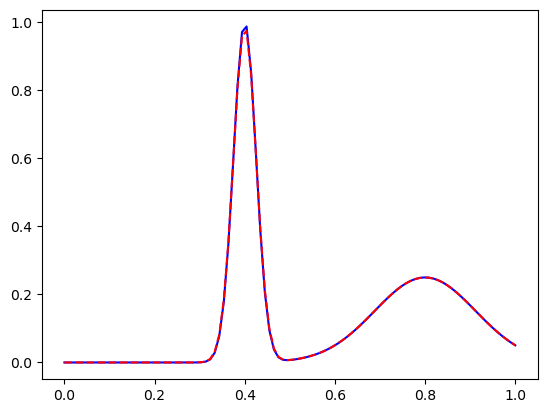

In [78]:
f = lambda x: (np.exp(-800*(x-0.4)**2)*((-1600*(x-0.4))**2-1601) + 0.25*np.exp(-40*(x-0.8)**2)*((-80*(x-0.8))**2-81))


c = u(0)
d = u(1)

N = 100
uhat = BVP1D(L=1, x=N, c=u(0), d=u(1), func=f, plot=None)

xax = np.linspace(0,1,100)
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)

plt.plot(xax, u(xax), 'b-',label="Exact solution")
plt.plot(np.linspace(0,1,N), uhat, 'r--',label="FEM solution")

In [44]:
c = u(0)
d = u(1)
x = np.linspace(0,1,5)
u = lambda x: np.exp(-800*(x-0.4)**2) + 0.25 * np.exp(-40*(x-0.8)**2)

A, b = GlobalAssembly(c=c, d=d, func= u, x=x)
b

array([ 1.90546630e-12, -2.98833896e-04, -1.06198472e-02,  1.61793270e-01,
        5.04741295e-02])

*f)*

In [218]:
def DriverAMR17(L,c,d,VXc,func,tol, maxit):
    it = 0
    idxMarked = np.arange(len(VXc)-1)

    while len(idxMarked)>0 and it < maxit:
        idxs = np.arange(len(VXc))

        # sorter her efter value
        sort_indices_c = np.argsort(VXc)
        uc = BVP1D(L, VXc[sort_indices_c], c, d,func, plot=False)

        EToVc = np.vstack((idxs[:-1], idxs[1:])).T
        EToVf, VXf,Old2New = refine_marked(EToVc,VXc,idxMarked)

        sort_indices_f = np.argsort(VXf)
        uf = BVP1D(L, VXf[sort_indices_f], c, d,func, plot=False)
    
        # sorter her efter index
        uc = uc[np.argsort(sort_indices_c)]
        uf = uf[np.argsort(sort_indices_f)]

        err = compute_error_decrease(uc,uf,VXc,VXf,Old2New)

        print(err)
        idxMarked = np.where(err > tol)[0]
        print(idxMarked)
        EToVc, VXc, Old2New = refine_marked(EToVc,VXc,idxMarked)

        it +=1
        idxMarked = np.arange(len(VXc)-1)


    uc = BVP1D(L, VXc, c, d,func, plot=False)
    
    return VXc, uc, it,Old2New

In [223]:
VX = np.linspace(0,1,5)
VXc, uc, it,Old2New = DriverAMR17(L=1,c=u(0),d=u(1),VXc=VX,func=f,tol=10e-3,maxit=3)

0
[0.0034853  0.02189891 0.05344763 0.01933071]
[1 2 3]
1
[nan nan nan nan nan nan nan]
[]
2
[nan nan nan nan nan nan nan]
[]


C:\Users\jhvid\AppData\Local\Temp\ipykernel_25324\4192341093.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  K = lambda h: np.array([[1/h + h/3, -1/h + h/6], [-1/h + h/6, 1/h + h/3]])


In [52]:
def prep_grid(L,c,d,VXc,func):
    idxs = np.arange(len(VXc))
    idxMarked = idxs[:-1]

    # sorter her efter value
    sort_indices_c = np.argsort(VXc)
    uc = BVP1D(L, VXc[sort_indices_c], c, d,func, plot=False)

    EToVc = np.vstack((idxs[:-1], idxs[1:])).T


    EToVf, VXf,Old2New = refine_marked(EToVc,VXc,idxMarked)

    sort_indices_f = np.argsort(VXf)
    uf = BVP1D(L, VXf[sort_indices_f], c, d,func, plot=False)
    
    # sorter her efter index
    uc = uc[np.argsort(sort_indices_c)]
    uf = uf[np.argsort(sort_indices_f)]

    return uc,uf, VXc, VXf, EToVc, EToVf, Old2New

In [89]:
L = 1
c = 0
d = 1
VXc = np.linspace(0,1,5)
func = lambda x: 1*x

uc,uf, VXc, VXf, EToVc, EToVf, Old2New = prep_grid(L,c,d,VXc,func)

uc,uf, VXc, VXf, EToVc, EToVf, Old2New = prep_grid(L,c,d,VXf,func)

C:\Users\jhvid\AppData\Local\Temp\ipykernel_7292\4192341093.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  K = lambda h: np.array([[1/h + h/3, -1/h + h/6], [-1/h + h/6, 1/h + h/3]])
c:\Users\jhvid\anaconda3\envs\FEM\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [90]:
print(EToVc)
print()
print(EToVf)
print()
print(Old2New)


[[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]]

[[ 0  9]
 [ 1 10]
 [ 2 11]
 [ 3 12]
 [ 4 13]
 [ 5 14]
 [ 6 15]
 [ 7 16]
 [ 9  1]
 [10  2]
 [11  3]
 [12  4]
 [13  5]
 [14  6]
 [15  7]
 [16  8]]

[[ 0  9  1]
 [ 1 10  2]
 [ 2 11  3]
 [ 3 12  4]
 [ 4 13  5]
 [ 5 14  6]
 [ 6 15  7]
 [ 7 16  8]]
